# 0. 데이터 다운로드

In [1]:
cd /content/drive/My Drive/kaggle

/content/drive/My Drive/kaggle


In [ ]:
# kaggle 설치
!pip install kaggle

In [ ]:
# 본인 API 토큰 업로드
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jinseock95","key":"c1ad5e89684f7d85a8ab9208fc990758"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -1ha kaggle.json

kaggle.json


In [ ]:
# 해당 kaggle 데이터 API로 파일 다운로드
!kaggle competitions download -c Kannada-MNIST

  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 61.7MB/s]
  0% 0.00/33.1k [00:00<?, ?B/s]
100% 33.1k/33.1k [00:00<00:00, 4.53MB/s]
 52% 5.00M/9.71M [00:00<00:00, 43.1MB/s]
100% 9.71M/9.71M [00:00<00:00, 61.8MB/s]
  0% 0.00/818k [00:00<?, ?B/s]
100% 818k/818k [00:00<00:00, 53.8MB/s]


In [ ]:
# 파일 다운로드 확인
!ls

 Dig-MNIST.csv.zip	 sample_submission.csv	'W07_Kannada MNIST.ipynb'
 kaggle_사용하기.ipynb	 test.csv.zip
 kaggle.json		 train.csv.zip


# 1. 데이터 불러오기 및 탐색

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1-1. train, test 불러오기

In [5]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')

In [6]:
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Train data shape: (60000, 785)
Test data shape: (5000, 785)


## 1-2. label 분포 확인하기

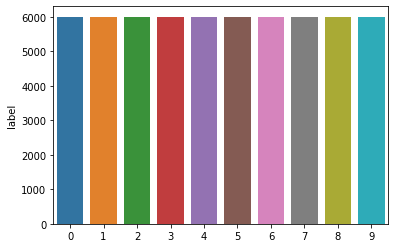

In [7]:
# label 분포 확인
label = train['label'].value_counts()
sns.barplot(label.index, label)
plt.show()

## 1-3. 각 label 시각화 해보기

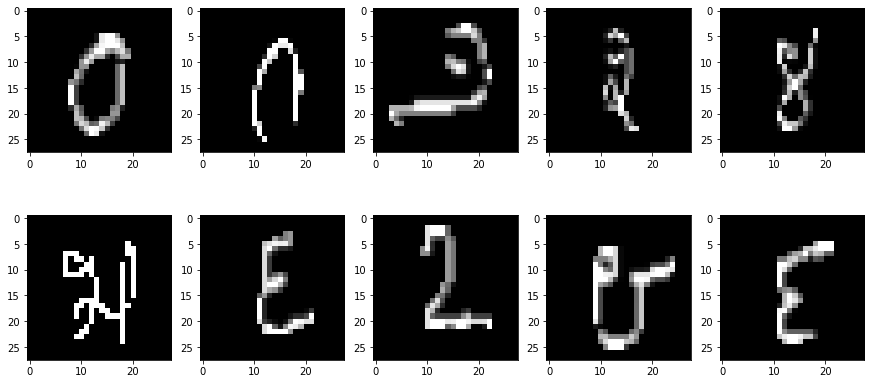

In [8]:
plt.figure(figsize = (15, 7))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  number = train.iloc[i, 1:].values.reshape(28, 28)
  plt.imshow(number, cmap='gray', interpolation='nearest')  

# 2. 데이터 전처리

## 2-1. 픽셀 정규화

In [9]:
# 각 픽셀의 범위는 0~255 -> 0~1로 정규화
# train
X = train.iloc[:, 1:].values.astype('float32') / 255
y = train['label']

In [10]:
# test
x_test = test.iloc[:, 1:].values.astype('float32') / 255

## 2-2. 이미지 처리를 위한 reshape

In [11]:
# 픽셀 데이터 reshape
X = X.reshape(-1, 28, 28,1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [12]:
X.shape, x_test.shape

((60000, 28, 28, 1), (5000, 28, 28, 1))

In [13]:
pd.get_dummies(y).values

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [14]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

## 2-3. 교차 검증을 위한 train-valid split

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [16]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

# 3. 모델링

## 3-1. Import modules

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D, LeakyReLU, ReLU, PReLU
from tensorflow.keras.optimizers import RMSprop, Nadam, Adadelta, Adam

## 3-2. 딥러닝 기본 (MLP)

In [18]:
model = Sequential() # 모델 생성
model.add(Flatten(input_shape=[28, 28])) # mlp 학습을 위해 1차원으로 flatten
model.add(Dense(300, activation='relu')) # hidden layer 뉴런=300 
model.add(Dense(100, activation='relu')) # 활성화함수 = relu
model.add(Dense(10, activation='softmax')) # 10개의 클래스 출력값 => 다중분류 softmax
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss = 'categorical_crossentropy', # 손실함수
             optimizer = 'adam', # 최적화
             metrics = ['accuracy']) # 정확도

In [20]:
history = model.fit(x_train, y_train, epochs=30,
                   validation_data = (x_val, y_val))

Epoch 1/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1386 - accuracy: 0.9601 - val_loss: 0.0689 - val_accuracy: 0.9793
Epoch 2/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0485 - accuracy: 0.9854 - val_loss: 0.0624 - val_accuracy: 0.9822
Epoch 3/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.0521 - val_accuracy: 0.9853
Epoch 4/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0209 - accuracy: 0.9931 - val_loss: 0.0474 - val_accuracy: 0.9868
Epoch 5/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0155 - accuracy: 0.9948 - val_loss: 0.0626 - val_accuracy: 0.9833
Epoch 6/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.0542 - val_accuracy: 0.9872
Epoch 7/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0563 - val_accuracy:

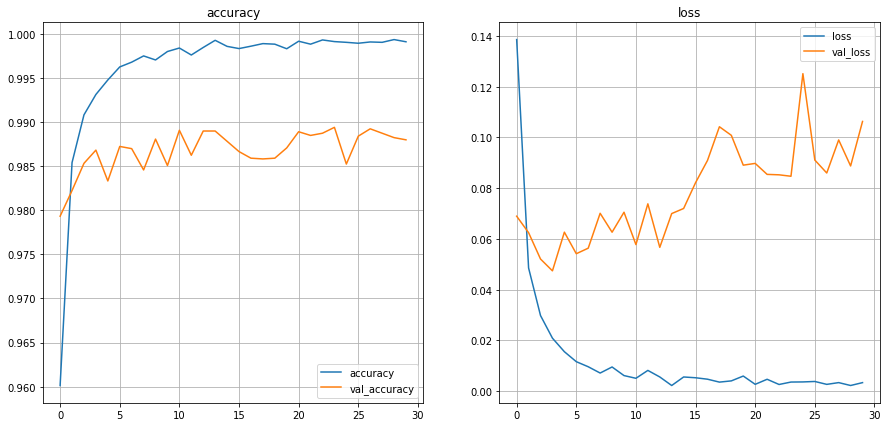

In [21]:
f, ax = plt.subplots(1,2, figsize = (15, 7))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].grid(True)
ax[0].set_title('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].grid(True)
ax[1].set_title('loss')

plt.show()

## 3-2. SOPCNN

Stochastic Optimization of Plain Convolutional Neural
Networks with Simple methods (2020, Yahia Saeed Assiri) [링크 텍스트](https://arxiv.org/pdf/2001.08856v1.pdf)

- MNIST 2020년 SOTA인 SOPCNN

In [22]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(2048),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)       

In [24]:
optimizer = Adam(learning_rate=0.01) # 논문 설정대로 0.01을 주었다.

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [25]:
history = model.fit(x_train, y_train, epochs=30,
                   validation_data = (x_val, y_val))

Epoch 1/30
1500/1500 [==============================] - 18s 12ms/step - loss: 135.5177 - accuracy: 0.8782 - val_loss: 12.8483 - val_accuracy: 0.9858
Epoch 2/30
1500/1500 [==============================] - 17s 12ms/step - loss: 34.7118 - accuracy: 0.9711 - val_loss: 23.2810 - val_accuracy: 0.9838
Epoch 3/30
1500/1500 [==============================] - 18s 12ms/step - loss: 194.2951 - accuracy: 0.9646 - val_loss: 96.8434 - val_accuracy: 0.9791
Epoch 4/30
1500/1500 [==============================] - 17s 12ms/step - loss: 121.3162 - accuracy: 0.9786 - val_loss: 54.1942 - val_accuracy: 0.9883
Epoch 5/30
1500/1500 [==============================] - 17s 12ms/step - loss: 494.2389 - accuracy: 0.9764 - val_loss: 140.2229 - val_accuracy: 0.9901
Epoch 6/30
1500/1500 [==============================] - 17s 12ms/step - loss: 132.6846 - accuracy: 0.9878 - val_loss: 75.4155 - val_accuracy: 0.9928
Epoch 7/30
1500/1500 [==============================] - 17s 12ms/step - loss: 368.6186 - accuracy: 0.9841 

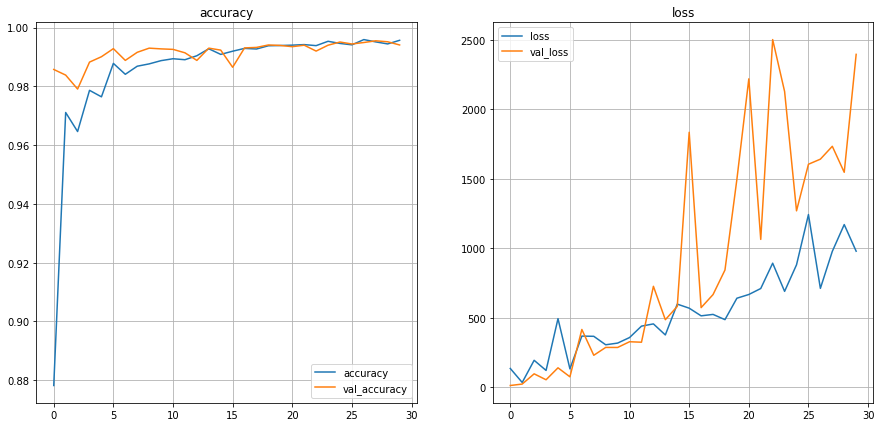

In [26]:
f, ax = plt.subplots(1,2, figsize = (15, 7))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].grid(True)
ax[0].set_title('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].grid(True)
ax[1].set_title('loss')

plt.show()

# 4. 추가 모델링

## 4-1. Data Augmentation, 데이터 증식을 통한 성능 향상

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
datagen_train = ImageDataGenerator(rotation_range = 15, # 돌리는 각도 
                             width_shift_range = 0.15, # 0.15 우로 이동, 1 이상이면 픽셀 수로 변환
                             height_shift_range = 0.15, # 0.15 위로 이동, 1 이상이면 픽셀 수로 변환
                             shear_range = 0.15, # 휘어짐 정도
                             zoom_range = 0.4,) # 확대 정도

In [31]:
datagen_train.fit(x_train)

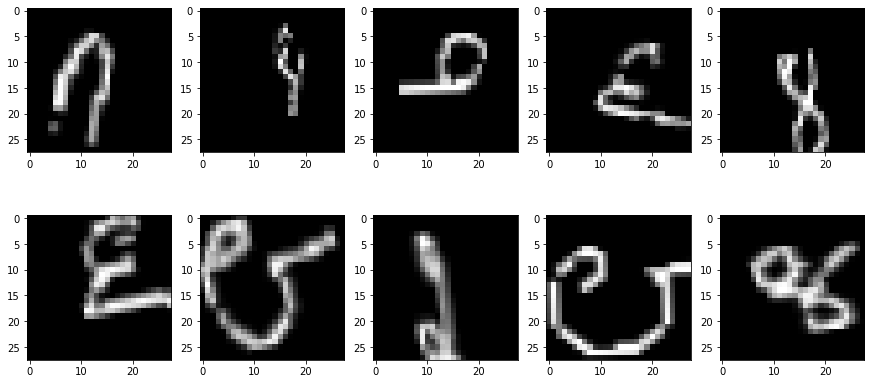

In [38]:
plt.figure(figsize = (15, 7))

for x_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=10):
	for i in range(0, 10):
		plt.subplot(2, 5, i + 1)
		plt.imshow(x_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	plt.show()
	break

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
datagen_val = ImageDataGenerator()

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='loss',    
    # Quantity to be monitored.
    factor=0.25,       
    # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,        
    # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         
    # 0: quiet - 1: update messages.
    mode="auto",       
    # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
    # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
    # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  
    # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        
    # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     
    # lower bound on the learning rate.
    )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

In [46]:
optimizer = Adam(learning_rate=0.01)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [47]:
batch_size = 40
step_train = x_train.shape[0] // batch_size
step_val = x_val.shape[0] // batch_size

history = model.fit(datagen_train.flow(x_train, y_train, batch_size = batch_size),
                              steps_per_epoch = step_train,
                              epochs = 30,
                              validation_data = (x_val, y_val),
                              callbacks = [learning_rate_reduction, es],
                              verbose = 2)

Epoch 1/30
1200/1200 - 19s - loss: 12412.1963 - accuracy: 0.7697 - val_loss: 235.3148 - val_accuracy: 0.9888
Epoch 2/30
1200/1200 - 19s - loss: 2041.9447 - accuracy: 0.8679 - val_loss: 110.4827 - val_accuracy: 0.9908
Epoch 3/30
1200/1200 - 19s - loss: 1468.3165 - accuracy: 0.8973 - val_loss: 135.3380 - val_accuracy: 0.9926
Epoch 4/30
1200/1200 - 19s - loss: 1054.9235 - accuracy: 0.9149 - val_loss: 200.5947 - val_accuracy: 0.9871
Epoch 5/30
1200/1200 - 19s - loss: 869.9484 - accuracy: 0.9241 - val_loss: 112.4732 - val_accuracy: 0.9926
Epoch 6/30
1200/1200 - 19s - loss: 750.2570 - accuracy: 0.9305 - val_loss: 133.8984 - val_accuracy: 0.9900
Epoch 7/30
1200/1200 - 19s - loss: 641.7711 - accuracy: 0.9345 - val_loss: 76.4702 - val_accuracy: 0.9922
Epoch 8/30
1200/1200 - 19s - loss: 550.0325 - accuracy: 0.9398 - val_loss: 105.0595 - val_accuracy: 0.9927
Epoch 9/30
1200/1200 - 19s - loss: 591.5588 - accuracy: 0.9384 - val_loss: 191.1477 - val_accuracy: 0.9937
Epoch 10/30
1200/1200 - 19s - los

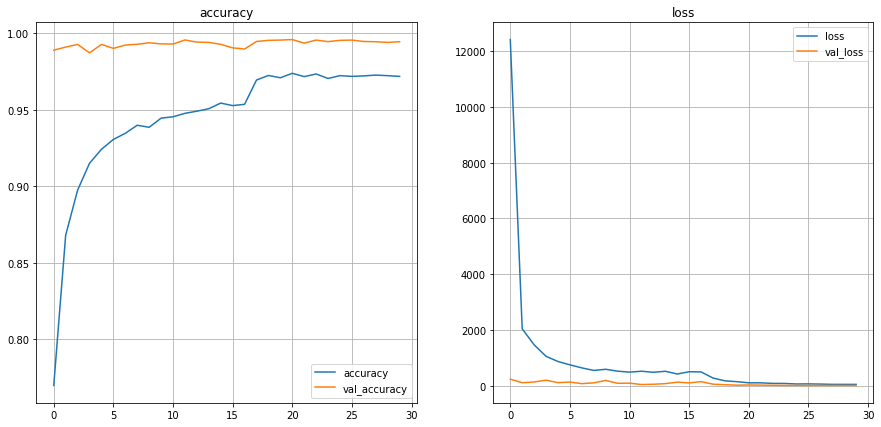

In [48]:
f, ax = plt.subplots(1,2, figsize = (15, 7))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].grid(True)
ax[0].set_title('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].grid(True)
ax[1].set_title('loss')

plt.show()

# 5. 제출

In [61]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5


In [53]:
pred = model.predict(x_test)

In [60]:
pred = np.argmax(pred, axis = 1)

In [63]:
sub['label'] = pred
sub.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [66]:
sub.to_csv('./submission.csv', index = False)